In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [48]:
df = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
X = df.drop("Rating", axis=1)
y = df['Rating']
X_test = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

# from sklearn.dummy import DummyClassifier
# model = DummyClassifier().fit(X,y)
# y_pred=model.predict(X_test)


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier


# Exploratory Data Analysis (EDA)

In [50]:
X.shape

(13636, 14)

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  BestScore          13636 non-null  int64 
 13  Recipe_Review      13634 non-null  object
dtypes: int64(9), object(5)
memory usage: 1.5+ MB


In [52]:
X.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [53]:
y.head()

0    5
1    5
2    3
3    5
4    4
Name: Rating, dtype: int64

In [54]:
y.shape

(13636,)

In [55]:
y.value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

## Handling Missing Values

In [56]:
X.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        2
dtype: int64

In [57]:
for c in X.columns:
    print(X[c].value_counts())
    print()
    print(X[c].isna().sum())
    print()
    print(X[c].unique())
    print()

ID
19     85
25     83
90     82
69     82
71     81
       ..
552     1
706     1
572     1
608     1
675     1
Name: count, Length: 701, dtype: int64

0

[ 70  72 458   7  60  36  96  59 179 702  22  83  34 106  76  61  92  44
 390 351 157   4  53 134 343 251 132 127  66  42  79 222   5 131 118  90
  95  23  40  77 142  58 114 119 112  73  84 138 414  13  57 125 321  46
 195  43  29 533 233  62 494 161  25  19  68 271 104  67  65 283  54   2
  74  80 105  88 287  78  11   8 117 346 137  97  93 231 113 110 158 153
 108  56  17 147 574 370 212  52  51 141 162  37 294 173 128   1  48  98
 415 149  55  99 150   0 225  39 197  47 521  35  33 136  45  10 201 180
 589 129 185  15 261 476  49  31 135 418 313  50  71 192 145 317 182 168
  12 420 199 216  21 188 345 115 238 166  18  63 101 140  16  82 368 357
 160  41  94 107 353  27 610 217 504 350 174 170 183 152   6 280 267  14
 247  38  81 549 326  28 194 248 139 286 277 100 175 156 330   9 650  69
  26  86 155 146 144 318 120 122 297 660 

# Data Visualisation

In [58]:
df_num=df.select_dtypes(include="number")

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'RecipeNumber'}>,
        <Axes: title={'center': 'RecipeCode'}>],
       [<Axes: title={'center': 'UserReputation'}>,
        <Axes: title={'center': 'CreationTimestamp'}>,
        <Axes: title={'center': 'ReplyCount'}>],
       [<Axes: title={'center': 'ThumbsUpCount'}>,
        <Axes: title={'center': 'ThumbsDownCount'}>,
        <Axes: title={'center': 'Rating'}>],
       [<Axes: title={'center': 'BestScore'}>, <Axes: >, <Axes: >]],
      dtype=object)

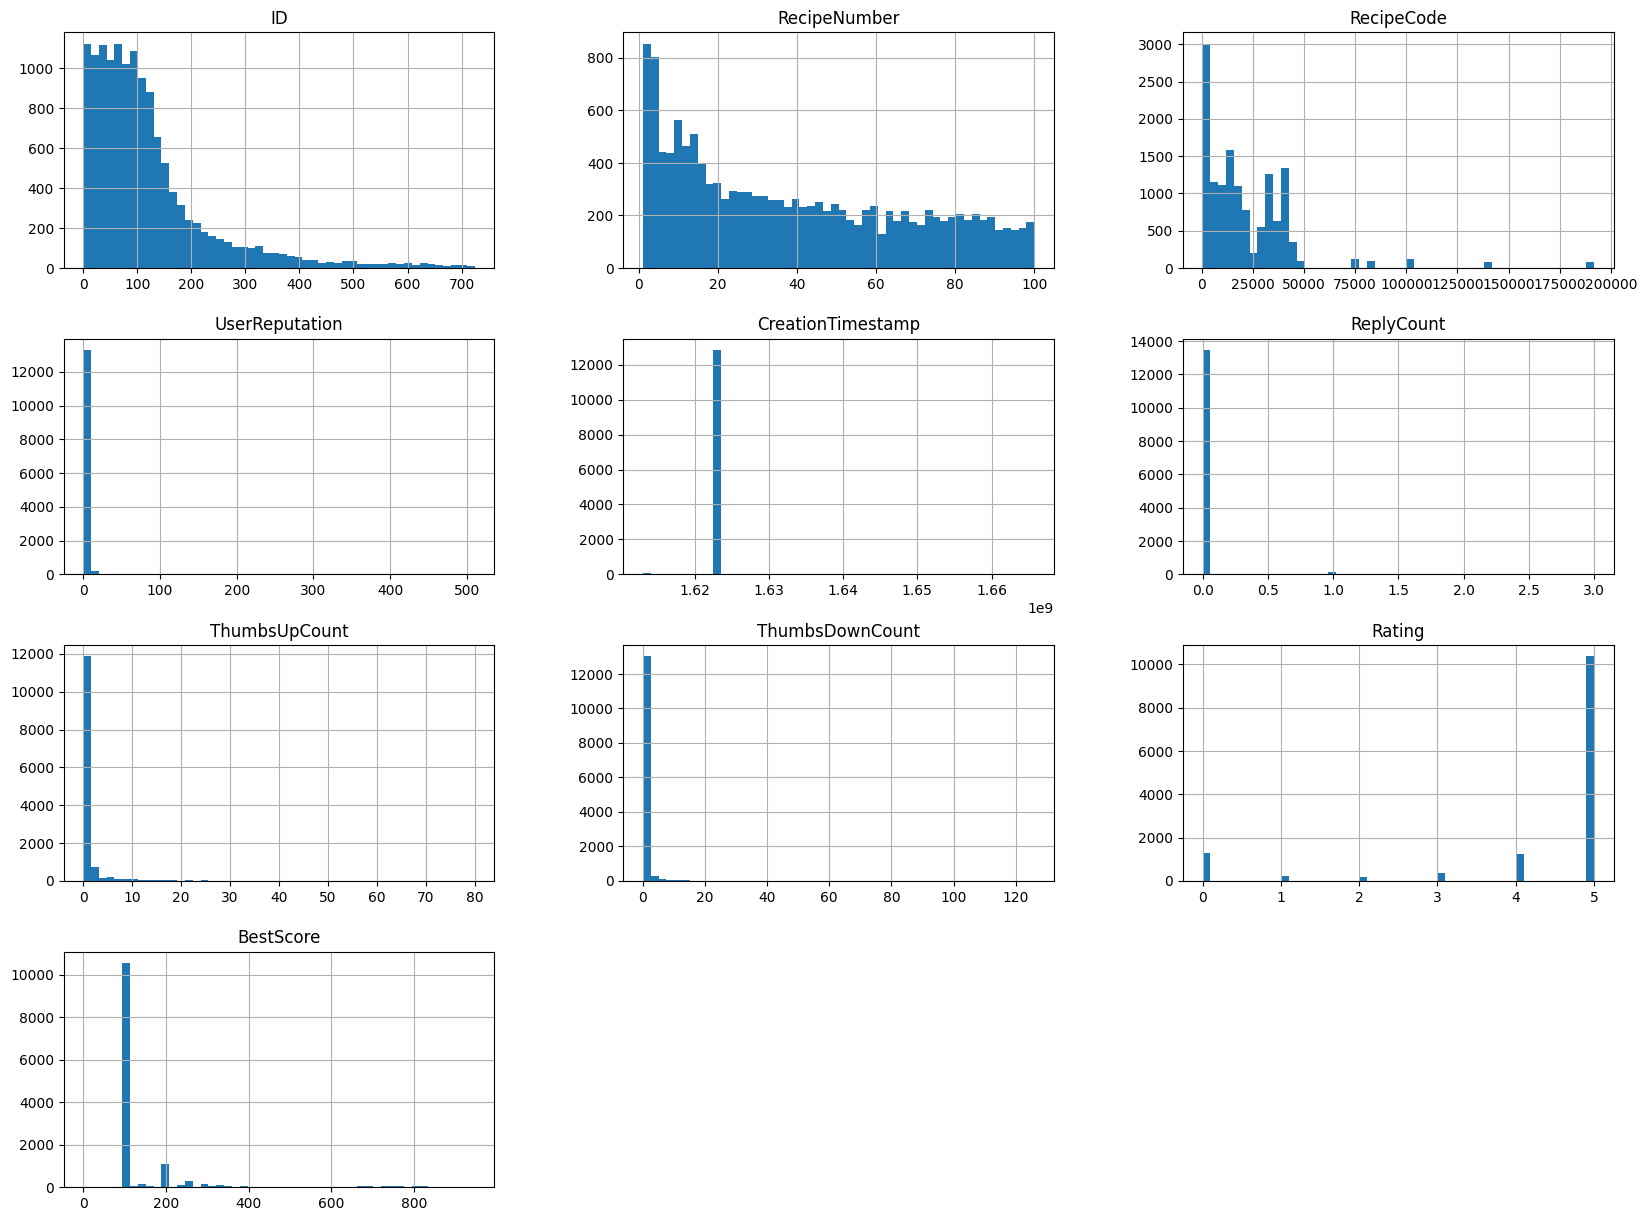

In [60]:
df.hist(bins=50, figsize=(20,15))

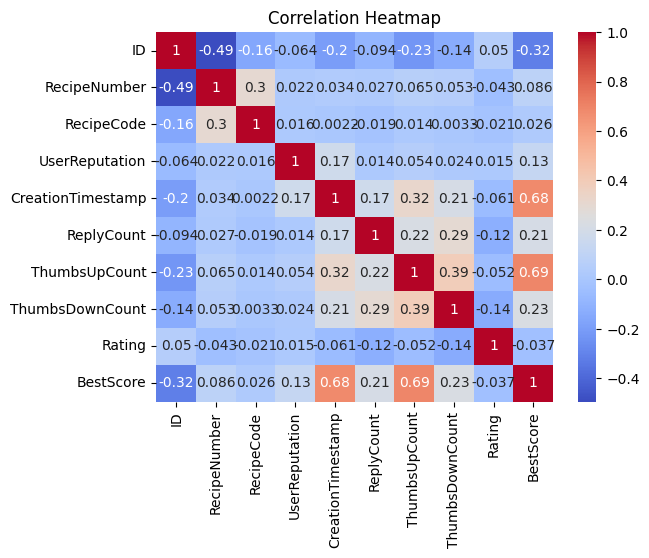

In [61]:
correlation_matrix = df_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### There seems to be a mild negative correlation between ThumbsDownCount and rating
### User Ratings does not have that much of an impact on ratings.
### Reply_count also shows a negative correlation with the ratings.

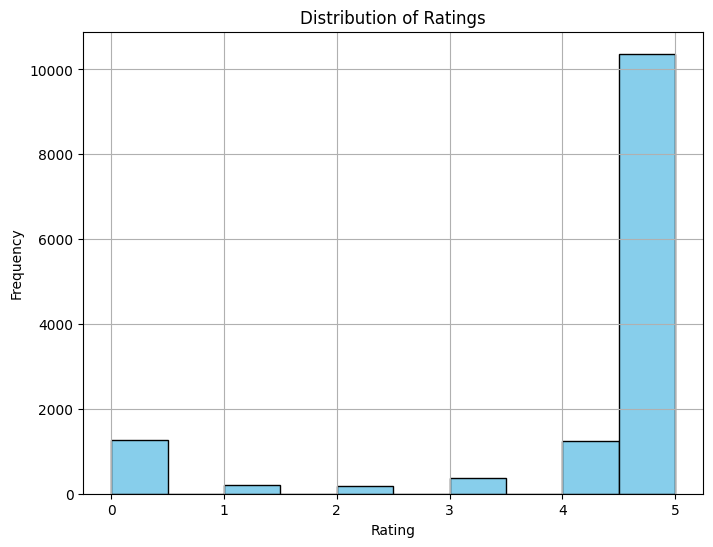

In [62]:
plt.figure(figsize=(8, 6))
plt.hist(df['Rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(True)
plt.show()

### In the rating (target variable), 5 occurs maximum number of times.

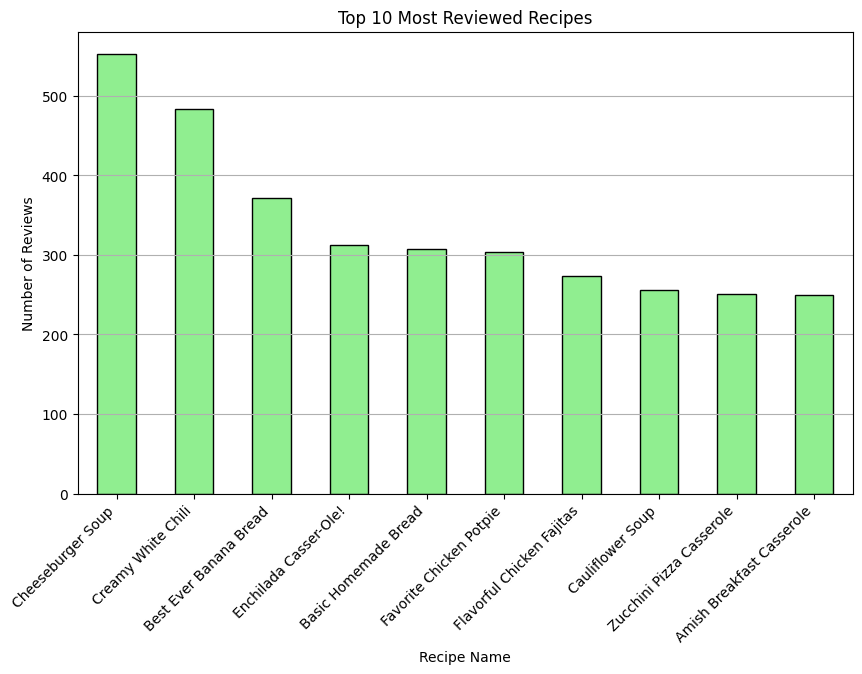

In [63]:
plt.figure(figsize=(10, 6))
top_10_recipes = df['RecipeName'].value_counts().head(10)
top_10_recipes.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Recipe Name')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Most Reviewed Recipes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

### Cheeseburger Soup is the recipe that is reviewd maximum number of times.

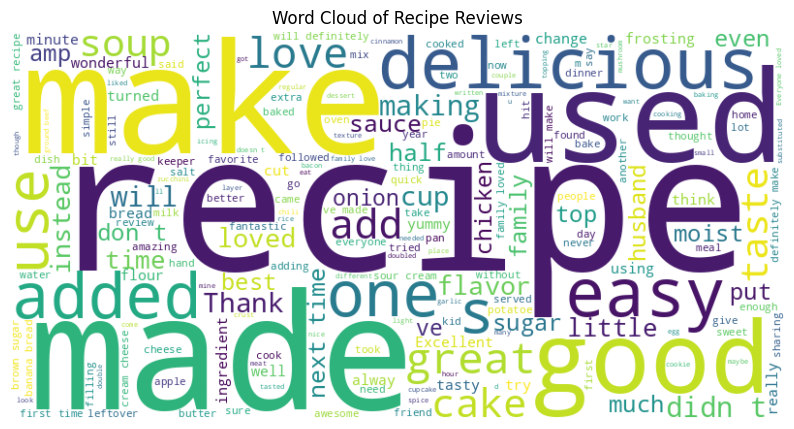

In [64]:
from wordcloud import WordCloud

# Drop rows with missing or NaN values in 'Recipe_Review' column
df.dropna(subset=['Recipe_Review'], inplace=True)

# Concatenate all the recipe reviews into a single string
text = ' '.join(df['Recipe_Review'].astype(str))

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Recipe Reviews')
plt.show()


### Recipe,made,used,made are the most common words used in Recipe Review.

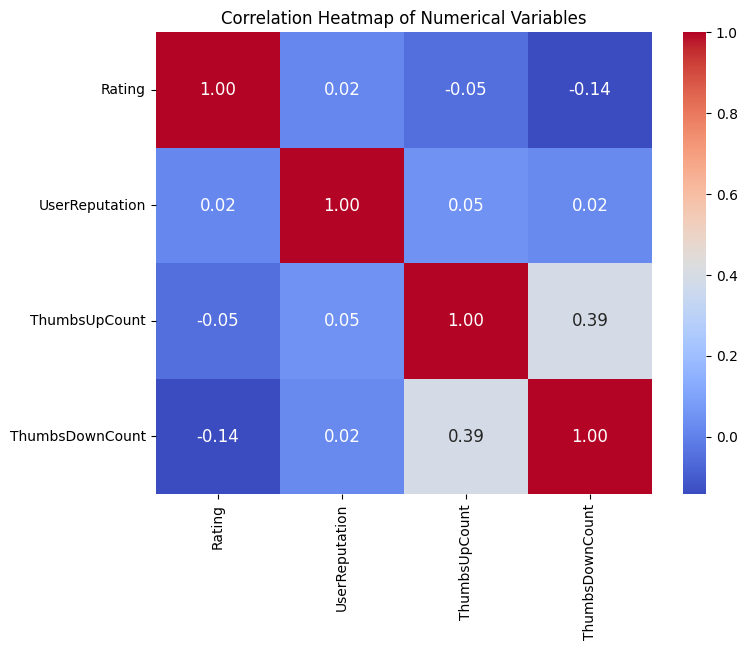

In [65]:
correlation_matrix = df[['Rating', 'UserReputation','ThumbsUpCount','ThumbsDownCount']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


### There seems to be a mild negative correlation between ThumbsDownCount and rating
### User Ratings does not have that much of an impact on ratings.
### Reply_count also shows a negative correlation with the ratings.

### We conclude after doing Exploratory Data Analysis that:
* Recipe_Review contains 2 null values
* In the rating (target variable), 5 occurs maximum number of times.
* There seems to be a mild negative correlation between ThumbsDownCount and rating
* User Ratings does not have that much of an impact on ratings.
* Cheeseburger Soup is the recipe that is reviewd maximum number of times.
* Reply_count also shows a negative correlation with the ratings.


### SimpleImputer and Standard Scaler

In [66]:
columns=X.columns

In [67]:
num_columns=X.select_dtypes(include="number").columns

In [68]:
# usage of column transformers

trf= [
    ("si_rn",SimpleImputer(strategy = "most_frequent"),["Recipe_Review"]),
    ("scaler",StandardScaler(),num_columns)
]

ct =ColumnTransformer(trf, remainder= "passthrough",verbose_feature_names_out=False).set_output(transform="pandas")

X=ct.fit_transform(X)
X_test=ct.fit_transform(X_test)

#insuring that the order of the columns remain same
X=pd.DataFrame(X,columns=columns)
X_test=pd.DataFrame(X_test,columns=columns)

In [69]:
X_test

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,-0.315577,0.203004,0.811566,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,-0.118157,-0.177493,-0.106916,-0.246877,-0.140798,-0.376856,This was so good!! The pumpkin was perfect as...
1,-0.177639,0.468555,-0.768046,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,-0.118157,-0.177558,-0.106916,-0.246877,0.107868,-0.376856,"So good! Could not stop eating them, so bad...."
2,0.287901,0.468555,-0.768046,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,-0.118157,-0.177445,-0.106916,-0.246877,-0.140798,-0.376856,I use a small ladle to fill muffin cups.
3,-0.901814,1.663536,-0.843183,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,-0.118157,-0.189974,-0.106916,0.682759,0.605200,0.415559,I made this and followed the instructions as d...
4,-0.824224,1.032852,0.434849,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,-0.118157,-0.177418,-0.106916,-0.246877,0.107868,-0.376856,Very Good! I used corn tortillas. Used fresh...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541,0.253417,-0.228517,-0.182853,Seafood Lasagna,sp_aUSaElGf_17310_c_310012,u_1oKYP0QIv00q3K9Z5U0TosT5gYx,jsantullo,-0.118157,-0.177519,-0.106916,-0.246877,-0.140798,-0.376856,This is an absolutely wonderful seafood recipe...
4542,-0.013838,1.165627,0.214807,Pineapple Pudding Cake,sp_aUSaElGf_26937_c_331905,u_1oKVlhuSfIH4M8gwWLvmkvs3215,homeoftaste,-0.118157,-0.177503,-0.106916,-0.246877,-0.140798,-0.376856,This us a definite &#34;OMG&#34;. Tastes sinf...
4543,0.089615,1.132433,0.799629,Contest-Winning New England Clam Chowder,sp_aUSaElGf_41095_c_112060,u_1oKVb3oC9QR5uDI8OqeaPncMtBe,cmfisher,-0.118157,-0.177699,-0.106916,-0.246877,-0.140798,-0.376856,absolutely great....even husband and grandson ...
4544,-0.272472,-0.892395,-0.082849,Cauliflower Soup,sp_aUSaElGf_19731_c_391682,u_1oKcs7T7xAY63ZrRKCwH8ccshww,danalu8,-0.118157,-0.177449,-0.106916,-0.246877,0.107868,-0.376856,I followed directions. It tastes very bland. V...


In [70]:
X.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
dtype: int64

## Splittiing the data

In [71]:
print(X.shape)
print(y.shape)

(13636, 14)
(13636,)


In [72]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
X_train_ref=X_train.drop(["CommentID","UserID","Recipe_Review","UserName","RecipeName"],axis=1)

X_ref=X.drop(["CommentID","UserID","Recipe_Review","UserName","RecipeName"],axis=1)

X_val_ref=X_val.drop(["CommentID","UserID","Recipe_Review","UserName","RecipeName"],axis=1)

X_test_ref=X_test.drop(["CommentID","UserID","Recipe_Review","UserName","RecipeName"],axis=1)

In [74]:
X_train_ref

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore
3717,-0.505040,0.282281,-0.250436,-0.115041,-0.182828,-0.105742,-0.263606,-0.166499,-0.376842
12430,-0.103301,-0.897312,-0.086047,-0.115041,-0.182784,-0.105742,-0.263606,-0.166499,-0.376842
532,-0.385373,0.080065,0.592991,-0.115041,-0.182926,-0.105742,-0.263606,-0.166499,-0.376842
10683,-0.838398,-0.863609,0.447779,-0.115041,1.567343,-0.105742,2.856643,11.776395,2.694477
11196,0.007819,2.001115,-0.419515,-0.115041,-0.182817,-0.105742,-0.263606,-0.166499,-0.376842
...,...,...,...,...,...,...,...,...,...
5191,1.213036,-0.931015,-0.409633,-0.115041,-0.182930,-0.105742,-0.263606,-0.166499,-0.376842
13418,0.050557,-0.155854,-0.108239,-0.115041,-0.182908,-0.105742,-0.263606,-0.166499,-0.376842
5390,-0.505040,0.113767,-0.483119,-0.115041,-0.183052,-0.105742,-0.263606,-0.166499,-0.376842
860,2.033610,-0.863609,0.447779,-0.115041,-0.182949,-0.105742,-0.263606,-0.166499,-0.376842


In [75]:
X_train_txt=X_train["Recipe_Review"].values.astype('U')

X_txt=X["Recipe_Review"].values.astype('U')

X_test_txt=X_test["Recipe_Review"].values.astype('U')

X_val_txt=X_val["Recipe_Review"].values.astype('U')

In [76]:
y.value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

In [77]:
print(X_train_ref["UserReputation"].value_counts())
print(X_train_ref["ReplyCount"].value_counts())


UserReputation
-0.115041     10178
 0.777280       365
 1.768748       178
-0.214188        98
 2.760216        41
 4.743152        12
 8.709024         7
 3.751684         5
 7.717556         4
 50.350682        3
 10.691961        3
 9.700493         3
 13.666365        2
 5.734620         2
 6.726088         2
 21.598109        1
 14.657833        1
 15.649301        1
 29.529853        1
 12.674897        1
Name: count, dtype: int64
ReplyCount
-0.105742     10768
 7.176605       126
 14.458952       10
 21.741299        4
Name: count, dtype: int64


In [78]:
print(X["UserID"].nunique())
print()
print(X["UserName"].value_counts())
print()
print(X.info())

10783

UserName
mjlouk               21
2124arizona          20
No_Time_To_Cook      20
grandmascooking22    19
justmbeth            18
                     ..
Melinda174            1
manncw408             1
grandmaomaha          1
geojac                1
morgantowndan         1
Name: count, Length: 10620, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 13636 non-null  float64
 1   RecipeNumber       13636 non-null  float64
 2   RecipeCode         13636 non-null  float64
 3   RecipeName         13636 non-null  object 
 4   CommentID          13636 non-null  object 
 5   UserID             13636 non-null  object 
 6   UserName           13636 non-null  object 
 7   UserReputation     13636 non-null  float64
 8   CreationTimestamp  13636 non-null  float64
 9   ReplyCount         13636 non-null  f

In [79]:
X_val_ref.shape

(2728, 9)

# Pre-Processing and Feature Engineering

## Standard Scaler

from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_train_final=ss.fit_transform(X_train_ref)
X_val_final=ss.fit_transform(X_val_ref)
X_test_final=ss.fit_transform(X_test_ref)
X_final=ss.fit_transform(X_ref)

X_train_final

## Tfidf

In [80]:
tfidf= TfidfVectorizer()

In [81]:
X_txt

array(['great recipe! I have made them just as written, wonderfull, moist, delicate flavor...then the next time, I did not have sour cream so used vanilla yogurt and added toffee pieces- still good.  I have made them as cupcakes and they rise very nicely and stay moist.',
       'This is an easy and quick recipe that is great for the fall cool weather. I only made substitutions for things I did not have on hand such as making my own ranch dressing mix, replacing stewed tomatoes with diced tomatoes with onion powder, and using chili hot beans instead of the drained pinto beans and can of green chilies. If I had all of the ingredients on hand, I wouldn&#39;t have changed anything.',
       'I think I was looking for something extra special in this soup, but it wasn&#39;t there--quite a bit of work for something that tasted merely average.',
       ..., 'Very tasty!',
       'I have made this numerous times.  It&#39;s so good &amp; easy!',
       'Super. I added 1/2 lb chopped bacon to mi

In [82]:
X_txt_vec=tfidf.fit_transform(X_txt)
X_train_txt_vec=tfidf.transform(X_train_txt)
X_val_txt_vec=tfidf.transform(X_val_txt)
X_test_txt_vec=tfidf.transform(X_test_txt)

In [83]:
X_train_st=np.hstack([X_train_ref,X_train_txt_vec.toarray()])
X_val_st=np.hstack([X_val_ref,X_val_txt_vec.toarray()])
X_test_st=np.hstack([X_test_ref,X_test_txt_vec.toarray()])
X_st=np.hstack([X_ref,X_txt_vec.toarray()])

In [84]:
print(X_train_st.shape)
print(X_val_st.shape)
print(X_test_st.shape)
print(X_st.shape)

(10908, 10489)
(2728, 10489)
(4546, 10489)
(13636, 10489)


In [85]:
y.value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

## Class Imbalance

In [88]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_trans,y_train_trans=smote.fit_resample(X_train_st,y_train)

y_train_trans.value_counts()

X_train_trans.shape

X_train_trans

y_train_trans.value_counts()

Rating
5    8310
1    8310
2    8310
4    8310
3    8310
0    8310
Name: count, dtype: int64

### SelectKBest

In [89]:
num_columns=X.select_dtypes(include="number")
cat_columns=X.select_dtypes(exclude="number")

In [90]:
from sklearn.feature_selection import SelectKBest,f_classif
skb=SelectKBest(score_func=f_classif,k=10)
X_new = skb.fit_transform(X_st, y)
X_train_new=skb.transform(X_train_st)
X_val_new=skb.transform(X_val_st)
X_test_new=skb.transform(X_test_st)


In [91]:
X_new.shape

(13636, 10)

# Logistic Regression

In [147]:
lr=LogisticRegression(max_iter=1000,solver='lbfgs',random_state=42)
lr.fit(X_train_trans,y_train_trans)

LogisticRegression(max_iter=1000, random_state=42)

In [148]:
y_val_lr=lr.predict(X_val_st)
print(y_val_lr)

[3 5 4 ... 5 4 0]


In [149]:
mse_lr=mean_squared_error(y_val,y_val_lr)
rmse_lr=np.sqrt(mse_lr)
rmse_lr
#1.654439508708777
#2.0456663298636535

2.0456663298636535

In [95]:
# lr_scores=cross_val_score(lr, X_val_st, y_val,scoring="neg_mean_squared_error", cv=5)
# lr_rmse_scores=np.sqrt(-lr_scores)
# lr_rmse_scores.mean()


In [150]:
y_pred_lr=lr.predict(X_test_st)
y_pred_lr

array([5, 5, 0, ..., 5, 1, 3])

In [151]:
y_pred_val_lr=lr.predict(X_val_st)
y_pred_val_lr

array([3, 5, 4, ..., 5, 4, 0])

In [152]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_val_lr))
# Training Accuracy: 0.7646627565982405
# Training Accuracy: 0.6370967741935484

Training Accuracy: 0.6370967741935484


The model is also performed on Transformed Dataset and it performs worse than non transformed dataset.

Training Accuracy: 0.6370967741935484
              precision    recall  f1-score   support

           0       0.23      0.36      0.28       257
           1       0.32      0.39      0.35        41
           2       0.14      0.18      0.16        34
           3       0.24      0.27      0.25        85
           4       0.24      0.40      0.30       250
           5       0.88      0.73      0.80      2061

    accuracy                           0.64      2728
   macro avg       0.34      0.39      0.36      2728
weighted avg       0.72      0.64      0.67      2728



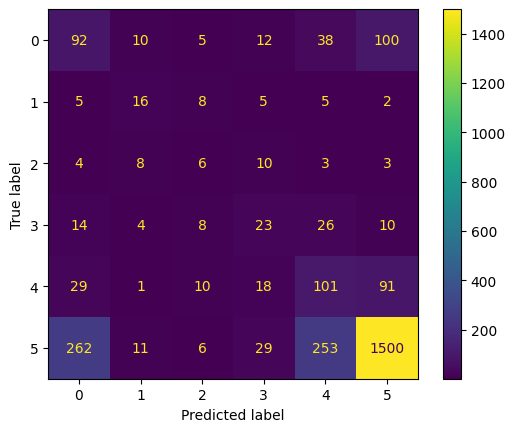

In [153]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_val_lr))

print(classification_report(y_val,y_pred_val_lr))

print(ConfusionMatrixDisplay.from_predictions(y_val,y_pred_val_lr))

### Hyper-Parameter Tuning

from sklearn.model_selection import RandomizedSearchCV

hyper_pipe=LogisticRegression()

grid={"max_iter" : [300,500,1000], "solver" : ['lbfgs','newton-cg'], "random_state" :[42]
     }

gscv = RandomizedSearchCV(estimator=hyper_pipe,
             param_distributions= grid,
             scoring = "neg_mean_squared_error",
             cv= 2,
             n_jobs = -1)
gscv

gscv.fit(X_train_new,y_train)

gscv.best_params_

y_lr_hyp=gscv.predict(X_val_new)
print(y_lr_hyp)

print("Training Accuracy:",accuracy_score(y_val,y_lr_hyp))

# SGDClassifier

from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(random_state=42)

sgd.fit(X_train_st,y_train)

y_pred_sgd=sgd.predict(X_val_st)
y_pred_sgd

mse_sgd=mean_squared_error(y_val,y_pred_sgd)
rmse_sgd=np.sqrt(mse_sgd)
rmse_sgd

Cross validation

print("Training Accuracy:",accuracy_score(y_val,y_pred_sgd))

# XGBoost

In [100]:
import xgboost

xgb=xgboost.XGBClassifier(random_state=42)

xgb.fit(X_train_st,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [101]:
y_pred_xgb=xgb.predict(X_val_st)

In [102]:
mse_xgb=mean_squared_error(y_val,y_pred_xgb)
rmse_xgb=np.sqrt(mse_xgb)
rmse_xgb

1.5760301290717558

In [103]:
# xgb_scores=cross_val_score(xgb, X_val_st, y_val,scoring="neg_mean_squared_error", cv=5)
# xgb_rmse_scores=np.sqrt(-xgb_scores)
# xgb_rmse_scores.mean()


In [104]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_xgb))

Training Accuracy: 0.7719941348973607


In [105]:
y_pred_xgb_test=xgb.predict(X_test_st)

Training Accuracy: 0.7719941348973607
              precision    recall  f1-score   support

           0       0.62      0.15      0.24       257
           1       0.61      0.27      0.37        41
           2       0.25      0.09      0.13        34
           3       0.37      0.08      0.13        85
           4       0.29      0.08      0.13       250
           5       0.80      0.98      0.88      2061

    accuracy                           0.77      2728
   macro avg       0.49      0.28      0.31      2728
weighted avg       0.71      0.77      0.71      2728



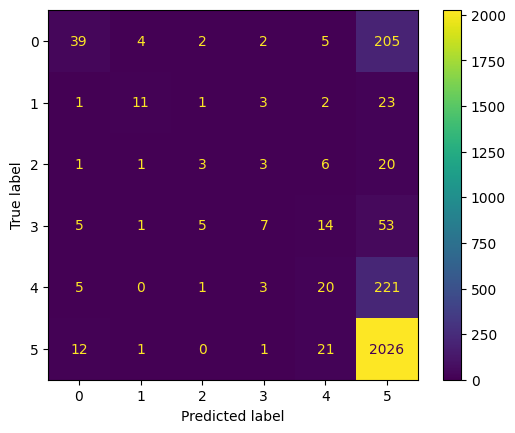

In [106]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_xgb))

print(classification_report(y_val,y_pred_xgb))

print(ConfusionMatrixDisplay.from_predictions(y_val,y_pred_xgb))

### Hyper-Parameter Tuning

import xgboost as xgb

hyper_pipe=xgb.XGBClassifier()

grid={"num_class" : [0.1,1],
     "n_estimators" : [80,100,120], "max_depth" : [5,10,15], "random_state" :[42], "learning_rate" :[0.3]
     }

rscv = RandomizedSearchCV(estimator=hyper_pipe,
             param_distributions= grid,
             scoring = "neg_mean_squared_error",
             cv= 3,
             n_jobs = -1)
rscv

rscv.fit(X_train_st,y_train)

rscv.best_estimator_

y_pred_xgb_rscv=rscv.predict(X_val_st)

y_pred_xgb_test=rscv.predict(X_test_st)

print("Training Accuracy:",accuracy_score(y_val,y_pred_xgb_rscv))

print(classification_report(y_val,y_pred_xgb_rscv))

print(ConfusionMatrixDisplay.from_predictions(y_val,y_pred_xgb_rscv))

# KNN Algorithm

In [107]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=15,weights="distance")
knn.fit(X_train_st,y_train)
y_pred_val_knn=knn.predict(X_val_st)

In [108]:
knn_mse=mean_squared_error(y_val,y_pred_val_knn)
knn_rmse=np.sqrt(knn_mse)
knn_rmse

1.6481127570114997

In [109]:
# knn_scores=cross_val_score(knn, X_val_ref, y_val, scoring="neg_mean_squared_error", cv=5)
# knn_rmse_scores=np.sqrt(-knn_scores)
# knn_rmse_scores.mean()

Training Accuracy: 0.7628299120234604
              precision    recall  f1-score   support

           0       0.51      0.09      0.15       257
           1       0.38      0.22      0.28        41
           2       0.00      0.00      0.00        34
           3       0.50      0.04      0.07        85
           4       0.56      0.02      0.04       250
           5       0.77      0.99      0.87      2061

    accuracy                           0.76      2728
   macro avg       0.45      0.23      0.23      2728
weighted avg       0.70      0.76      0.68      2728



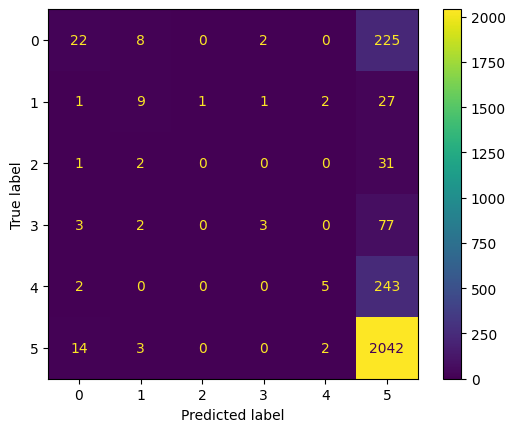

In [110]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_val_knn))

print(classification_report(y_val,y_pred_val_knn))

print(ConfusionMatrixDisplay.from_predictions(y_val,y_pred_val_knn))

Model was also performed on transformed Dataset but gave worse results in that.

In [111]:
y_pred_knn=knn.predict(X_test_st)

# Decision Tree Classifier

In [112]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier(max_depth=3)

In [113]:
dtc.fit(X_train_st,y_train)

DecisionTreeClassifier(max_depth=3)

from sklearn.model_selection import RandomizedSearchCV
grid={"max_depth" : [1,2,3,4],
     "min_weight_fraction_leaf" : [0,0.1,0.2,0.3,0.4,0.5]
     }

gscv3 = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
             param_distributions= grid,
             scoring = "neg_mean_squared_error",
             cv= 5,
             n_jobs = -1)
gscv3

gscv3.fit(X_st,y)

gscv3.best_estimator_

In [114]:
y_pred_dtc=dtc.predict(X_val_st)

In [115]:
mse_dtc=mean_squared_error(y_val,y_pred_dtc)
rmse_dtc=np.sqrt(mse_dtc)
rmse_dtc

1.7031323565850427

In [116]:
# dtc_scores=cross_val_score(gscv3, X_val_st, y_val, scoring="neg_mean_squared_error", cv=5)
# dtc_rmse_scores=np.sqrt(-dtc_scores)
# dtc_rmse_scores.mean()

In [117]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_dtc))

Training Accuracy: 0.7543988269794721


Model was also performed on transformed Dataset but gave worse results in that.

In [118]:
y_pred_dtc_test=dtc.predict(X_test_st)

# Random Forest Classifier

In [119]:
from sklearn.ensemble import RandomForestClassifier
rand=RandomForestClassifier(bootstrap=True,n_jobs=-1,n_estimators=15,max_leaf_nodes=8000)

In [120]:
rand.fit(X_train_st,y_train)

RandomForestClassifier(max_leaf_nodes=8000, n_estimators=15, n_jobs=-1)

In [121]:
y_pred_rand=rand.predict(X_val_st)

In [122]:
mse_rand=mean_squared_error(y_val,y_pred_rand)
rmse_rand=np.sqrt(mse_rand)
rmse_rand

1.663278569925381

In [123]:
# rand_scores=cross_val_score(rand, X_val_st, y_val, scoring="neg_mean_squared_error", cv=5)
# rand_rmse_scores=np.sqrt(-rand_scores)
# rand_rmse_scores.mean()

In [124]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_rand))

Training Accuracy: 0.7635630498533724


In [125]:
y_pred_rand_test=rand.predict(X_test_st)

Training Accuracy: 0.7635630498533724
              precision    recall  f1-score   support

           0       0.67      0.07      0.13       257
           1       0.25      0.02      0.04        41
           2       0.00      0.00      0.00        34
           3       0.33      0.02      0.04        85
           4       0.47      0.04      0.07       250
           5       0.77      1.00      0.87      2061

    accuracy                           0.76      2728
   macro avg       0.42      0.19      0.19      2728
weighted avg       0.70      0.76      0.68      2728



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


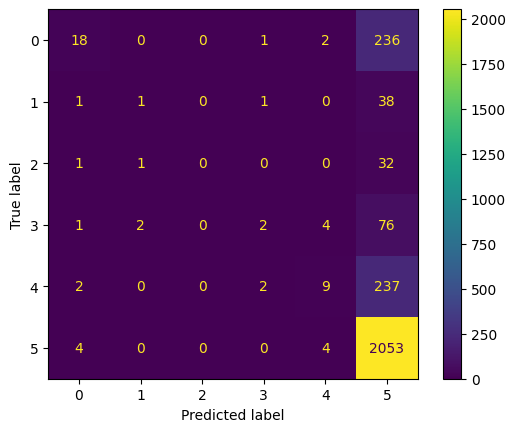

In [126]:
print("Training Accuracy:",accuracy_score(y_val,y_pred_rand))

print(classification_report(y_val,y_pred_rand))

print(ConfusionMatrixDisplay.from_predictions(y_val,y_pred_rand))

### Hyper-Parameter Tuning

grid2={ "n_estimators" : [15,25], "max_leaf_nodes" : [2000,8000,16000]
     }

gscv4 = GridSearchCV(estimator=RandomForestClassifier(),
             param_grid= grid2,
             scoring = "neg_mean_squared_error",
             cv= 2,
             n_jobs = -1)
gscv4

gscv4.fit(X_train_st,y_train)

gscv4.best_params_
result is n_estimators=15, and max_leaf_nodes=8000

y_pred_rand_hyp=gscv4.predict(X_val_st)

mse_rand=mean_squared_error(y_val,y_pred_rand_hyp)
rmse_rand=np.sqrt(mse_rand)
rmse_rand

print("Training Accuracy:",accuracy_score(y_val,y_pred_rand_hyp))
this came to be 76.2

y_pred_rand_hyp_test=gscv4.predict(X_test_st)

# Comparision Of Performance of Various Models

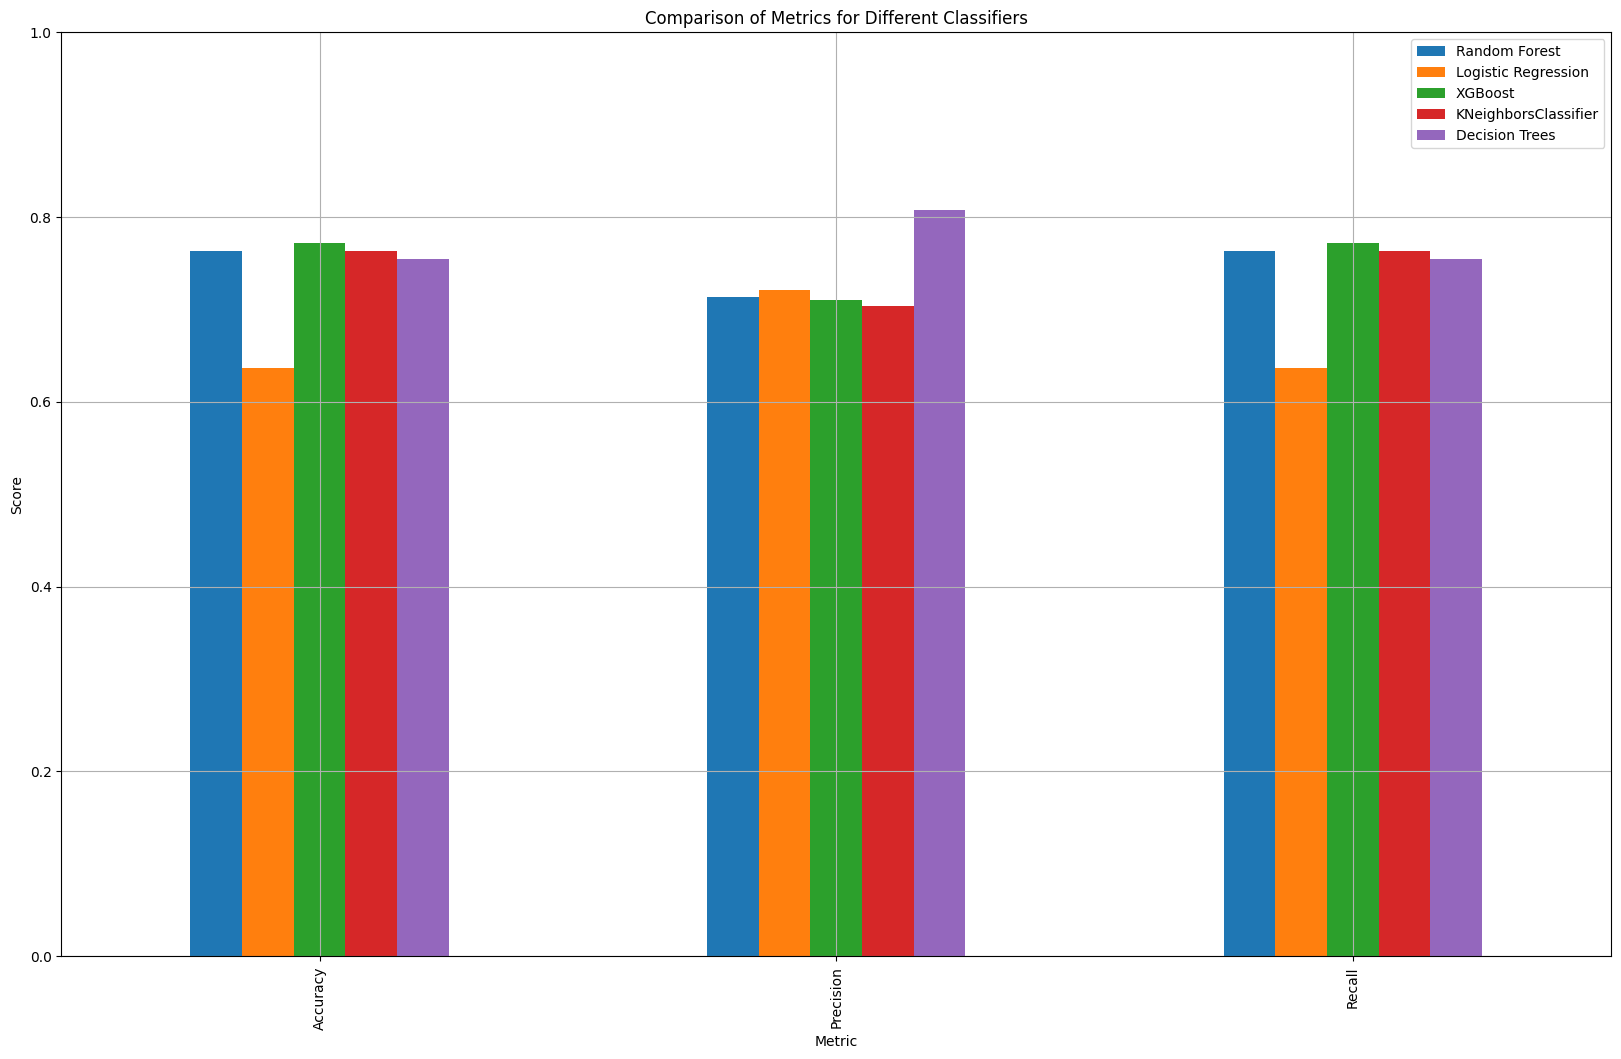

In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define a list of classifiers with their fitted models
fitted_classifiers = {
    'Random Forest': rand,
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'KNeighborsClassifier': knn,
    'Decision Trees': dtc
}

metrics = {}
for clf_name, clf in fitted_classifiers.items():
    y_pred = clf.predict(X_val_st)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted',zero_division=1)
    recall = recall_score(y_val, y_pred, average='weighted')
    metrics[clf_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}

# Convert metrics to DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics)

# Plotting
metrics_df.plot(kind='bar', figsize=(20, 12))
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Comparison of Metrics for Different Classifiers')
plt.ylim(0, 1)  # Setting y-axis limit for better visualization
plt.grid(True)
plt.show()

# Submission

In [154]:
submission = pd.DataFrame({"ID": range(1,4547), 
                           "total_amount": y_pred_xgb_test}) 

submission.to_csv('submission.csv',index=False) 